# Content and Objectives

- Show effects of multipath on a pulse and on a pulse-shaped data signal for random data

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

# Function for determining the impulse response of an RC filter

In [3]:

########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: roll-off factor must not equal zero
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, sps factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    if beta == 0:
        beta = 1e-32
    
    K = int(K) 

    if ( K%2 == 0):
        raise ValueError('Length of the impulse response should be an odd number')
    
        
    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = range( -(K-1)//2, (K-1)//2+1)

    # assign values of rrc
    for t_i in time_ind:
        t = (t_i)* t_sample    

        if t_i == 0:
            rrc[ int( t_i+(K-1)//2 ) ] = (1-beta+4*beta/np.pi)

        elif np.abs(t) == t_symbol / ( 4 * beta ):             
            rrc[ int( t_i+(K-1)//2 ) ] = beta*np.sin( np.pi/(4*beta)*(1+beta) ) \
                - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 

        else:
            rrc[ int( t_i+(K-1)//2 ) ] = ( 4 * beta * t / t_symbol * np.cos( np.pi*(1+beta)*t/t_symbol ) \
                + np.sin( np.pi * (1-beta) * t / t_symbol ) ) / ( np.pi * t / t_symbol * (1-(4*beta*t/t_symbol)**2) )

    rrc = rrc  / np.sqrt(t_symbol)
               
    return rrc  

# Parameters

In [4]:
# parameters of the filter
beta = 0.33

n_sps = 8           # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

# set symbol time 
t_symb = 1.0 

# switch for normalizing all signals in order to only look at their shape and not their energy
normalize_signals = 1

# Define Channel

In [5]:
# defining delays of multi-path and their weight
# NOTE: No "sanity check" if lengths correspond, so errors may occurr

# choose whether delays of multipath are 
# (0) in multiples of the symbol time t_sym or
# (1) in multiples of the sampling time t_sym / n_sps

channel_factors = [ 1.0, .5, .1 ]

delay_type = 1

if delay_type == 0: 
    # construction based on delays w.r.t. symbol time
    channel_delays_syms = np.array( [ 1, 3, 5 ] )
    channel_delays_samples = n_sps * channel_delays_syms
    
else:
    # "fractional delays", i.e. delays w.r.t. t_sym / n_sps
    channel_delays_samples = np.array( [ 1, 12, 15 ] )

h_channel = np.zeros( np.max(channel_delays_samples ) + 1 )

for k in np.arange( len(channel_delays_samples) ):
    h_channel[ channel_delays_samples[k] ] = channel_factors[k]

# Pulse Shape and Effect of Multi-Path on Pulse Shape

In [6]:
rrc = get_rrc_ir( K_filt, n_sps, t_symb, beta)

r_rrc = np.convolve( rrc, h_channel )

if normalize_signals:
    rrc /= np.linalg.norm( rrc )
    r_rrc /= np.linalg.norm( r_rrc )

### show pulse and version after multi-path

Text(0.5, 0, '$n/t$')

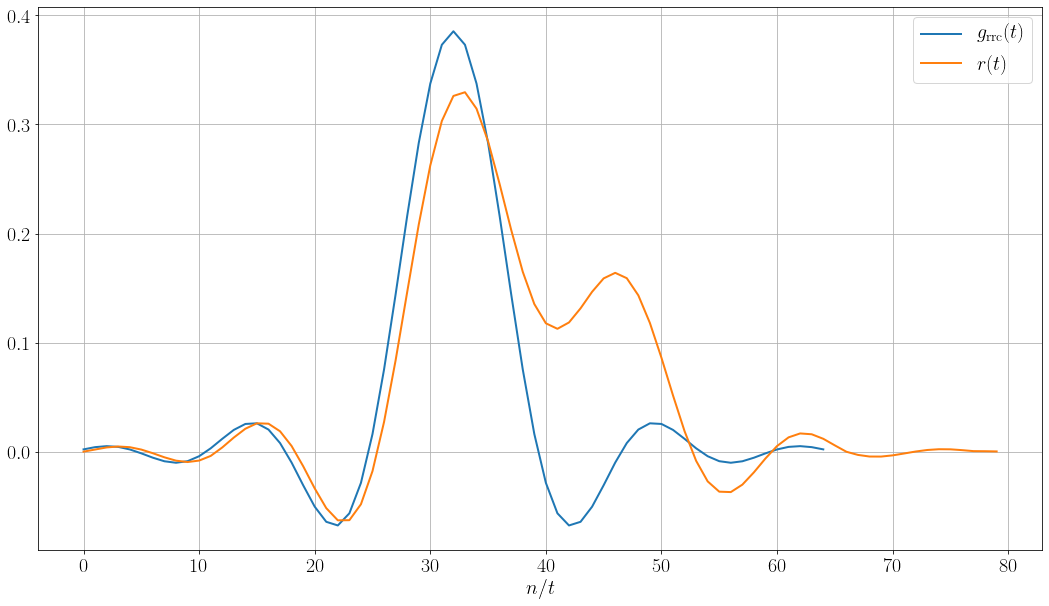

In [7]:
plt.figure()    

plt.plot( np.arange(len(rrc)), rrc, linewidth=2.0, label='$g_{\\mathrm{rrc}}(t)$')    
plt.plot( np.arange(len(r_rrc)), r_rrc, linewidth=2.0, label='$r(t)$')    


plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n/t$')

### show spectra

+ **Note:** Both spectra are normalized to have equal energy in frequency regime 

In [8]:
rrc_padded = np.hstack( ( rrc , np.zeros( 9*len(rrc) ) ) )
rrc_padded = np.roll( rrc_padded, -( K_filt - 1 ) // 2 )

RRC = np.fft.fft( rrc_padded )


r_rrc_padded = np.hstack( ( r_rrc , np.zeros( 10*len(rrc) - len( r_rrc ) ) ) )
r_rrc_padded = np.roll( r_rrc_padded, -( K_filt - 1 ) // 2 )

R_rrc = np.fft.fft( r_rrc_padded )


if normalize_signals:
    RRC /= np.linalg.norm( RRC )
    R_rrc /= np.linalg.norm( R_rrc )

f = np.linspace( -n_sps/(2*t_symb), n_sps/(2*t_symb), len(rrc_padded) )

Text(0.5, 0, '$f$')

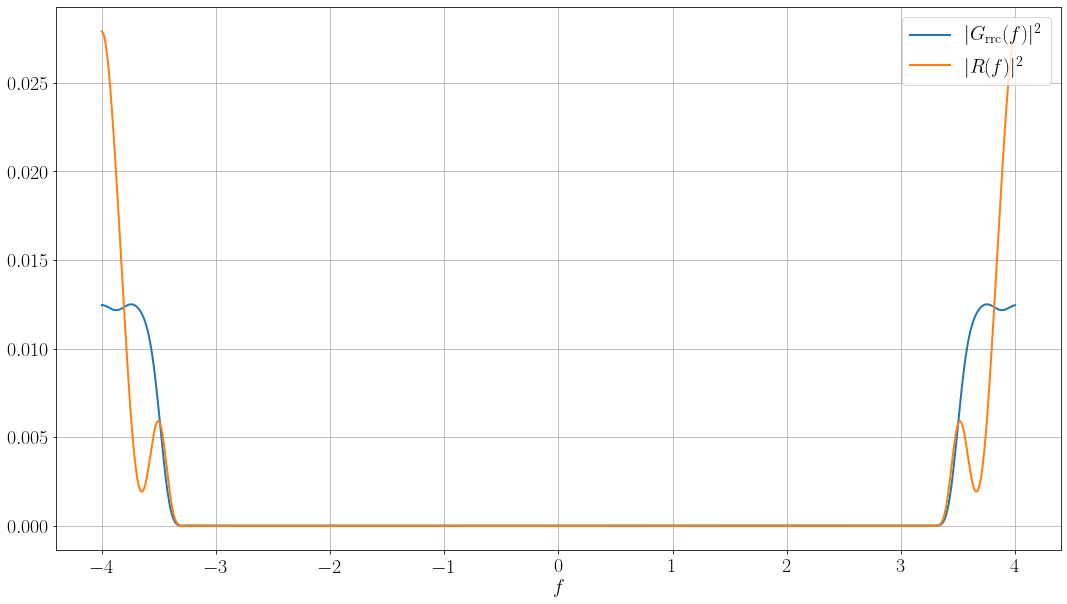

In [9]:
plt.figure()    

plt.plot( f, np.abs( RRC )**2, linewidth=2.0, label='$|G_{\\mathrm{rrc}}(f)|^2$')    
plt.plot( f, np.abs( R_rrc )**2, linewidth=2.0, label='$|R(f)|^2$')    

plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$f$')

**Note:** Spectrum is shown to emphasize that pulse shape might be distorted.


# Real Data Modulated Tx-signal

In [10]:
# number of symbols and samples per symbol
n_symb = 8

# modulation scheme and constellation points
constellation = np.array( [ 1 , -1] )

In [11]:
# generate random binary vector and modulate the specified modulation scheme
d = np.random.randint( 2, size = n_symb )
s = constellation[ d ]

# prepare sequence to be filtered by upsampling 
s_up = np.zeros( n_symb * n_sps, dtype=complex)        
s_up[ : : n_sps ] = s

s_up_delayed = np.hstack( ( np.zeros( (K_filt-1) // 2 ) , s_up ) ) 
s_up_delayed_delayed = np.hstack( ( np.zeros( K_filt-1 ), s_up ) )  

# apply RRC filtering        
s_Tx = np.convolve( s_up, rrc)  

rc = np.convolve( rrc, rrc)
s_rc = np.convolve( s_up, rc)

# get received signal
r = np.convolve( s_Tx, h_channel)

# apply MF at the Rx 
y_mf_rrc = np.convolve(r, rrc)
y_mf_no_channel = np.convolve( s_Tx, rrc )

# normalize signals if applicable
if normalize_signals:
    s_Tx /= np.linalg.norm( s_Tx )
    r /= np.linalg.norm( r )
    
    y_mf_rrc /= np.linalg.norm( y_mf_rrc )
    y_mf_no_channel /= np.linalg.norm( y_mf_no_channel )

### show signals

Text(0.5, 0, '$n$')

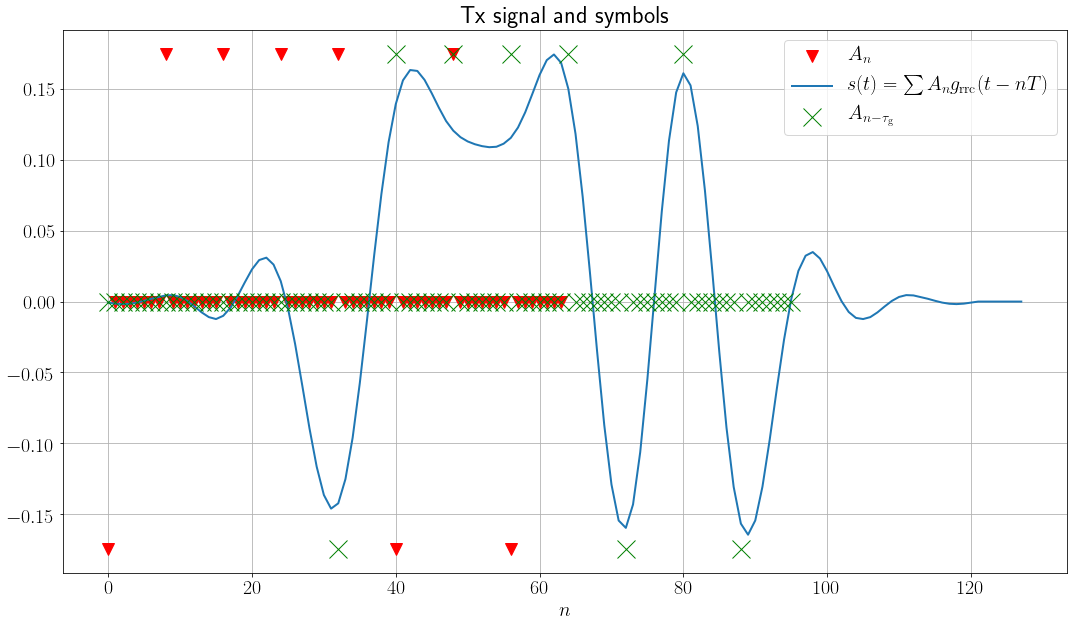

In [12]:
plt.plot( np.arange(len(s_up)), np.max(np.abs(s_Tx)) * np.real(s_up),'vr', ms=12, label='$A_n$')

plt.plot( np.arange(len(s_Tx)), np.real(s_Tx), linewidth=2.0, label='$s(t)=\sum A_ng_{\\mathrm{rrc}}(t-nT)$')    

plt.plot( np.arange(len(s_up_delayed)), np.max(np.abs(s_Tx)) * np.real(s_up_delayed),'xg', ms=18, label='$A_{n-\\tau_\mathrm{g}}$')

plt.title('Tx signal and symbols')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')


**Note I:**  The sybol values (except for scaling) may be obtained by sampling the signal $s(t)$ at times being delayed by $\tau_\mathrm{g}$, equaling the group delay of the pulse shaping filter.

**Note II:** So, in upcoming plots symbols $A_n$ (without delay) will be omitted and only $A_{n-\tau_\mathrm{g}}$ will be shown.

Text(0.5, 0, '$n$')

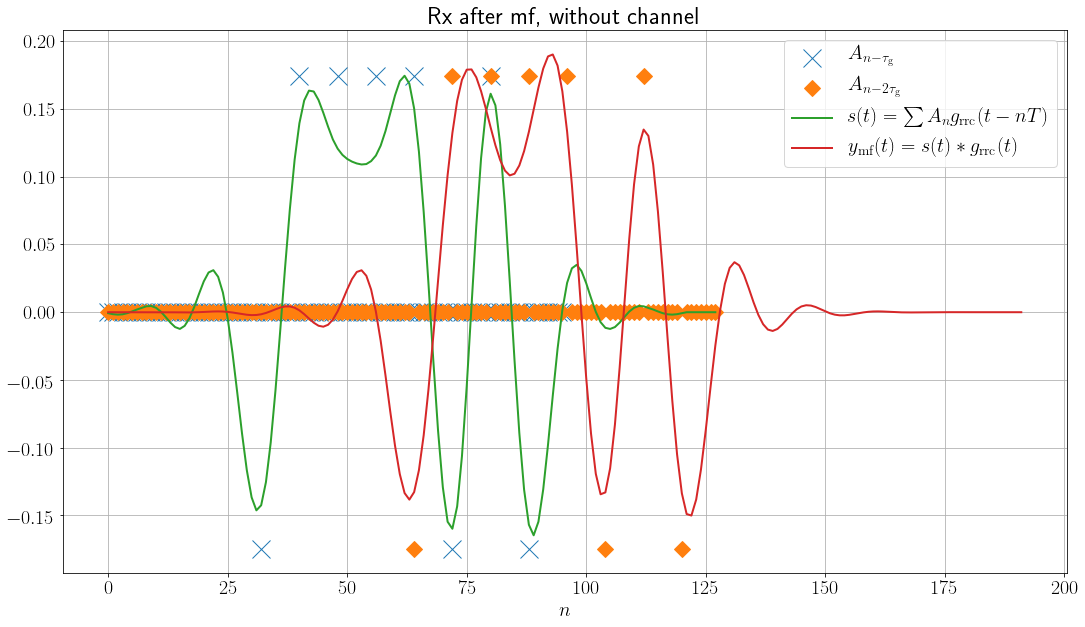

In [13]:
plt.plot( np.arange(len(s_up_delayed)), np.max(np.abs(s_Tx)) * np.real(s_up_delayed),'x', ms=18, label='$A_{n-\\tau_\mathrm{g}}$')    
plt.plot( np.arange(len(s_up_delayed_delayed)), np.max(np.abs(s_Tx)) * np.real(s_up_delayed_delayed),'D', ms=12, label='$A_{n-2\\tau_\mathrm{g}}$')    

plt.plot( np.arange(len(s_Tx)), np.real(s_Tx), linewidth=2.0, label='$s(t)=\sum A_ng_{\\mathrm{rrc}}(t-nT)$')    
plt.plot( np.arange(len(y_mf_no_channel)), np.real(y_mf_no_channel), linewidth=2.0, label='$y_{\\mathrm{mf}}(t)=s(t)* g_{\\mathrm{rrc}}(t)$')            

plt.title('Rx after mf, without channel')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')


**Note:** If the channel is perfect, i.e, no channel is active at all, then MF at the receiver--matched to rrc--leads to signal $y_\mathrm{rrc}(t)$ whose samples with delay $2\tau_\mathrm{g}$ corresponds to the transmitted symbols.

Text(0.5, 0, '$n$')

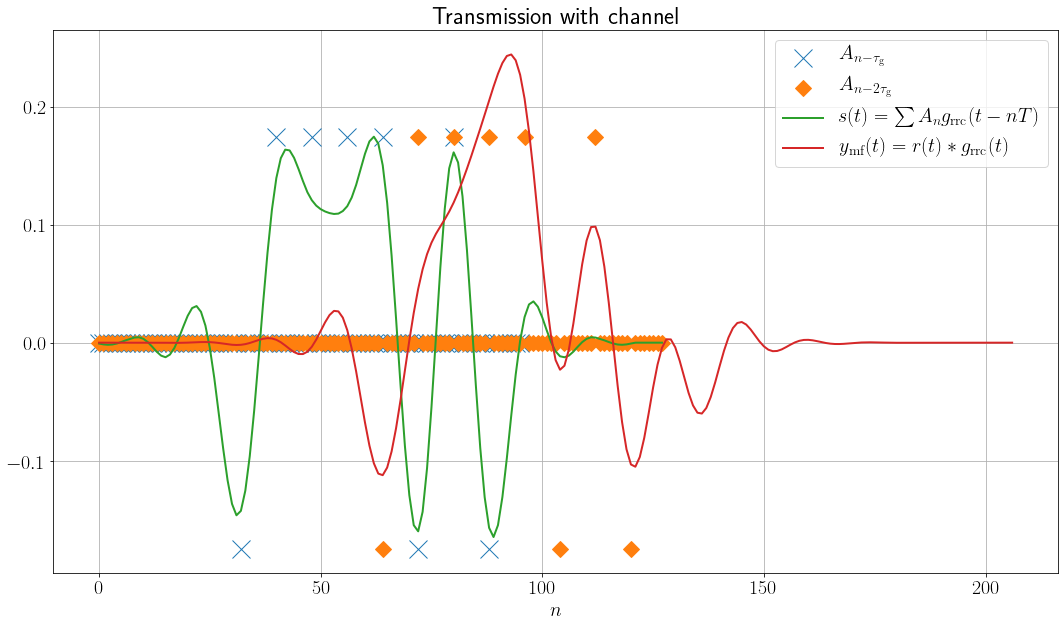

In [14]:
plt.plot( np.arange(len(s_up_delayed)), np.max(np.abs(s_Tx)) * np.real(s_up_delayed),'x', ms=18, label='$A_{n-\\tau_\mathrm{g}}$')    
plt.plot( np.arange(len(s_up_delayed_delayed)), np.max(np.abs(s_Tx)) * np.real(s_up_delayed_delayed),'D', ms=12, label='$A_{n-2\\tau_\mathrm{g}}$')    
                                  

plt.plot( np.arange(len(s_Tx)), np.real(s_Tx), linewidth=2.0, label='$s(t)=\sum A_ng_{\\mathrm{rrc}}(t-nT)$')    
#plt.plot( np.arange(len(r)), np.real(r), linewidth=2.0, label='$r(t)=s(t)*h(t)$')        
plt.plot( np.arange(len(y_mf_rrc)), np.real(y_mf_rrc), linewidth=2.0, label='$y_{\\mathrm{mf}}(t)=r(t)* g_{\\mathrm{rrc}}(t)$')            

plt.title('Transmission with channel')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')


**Note:** Now the channel is included; depending on the nature of the channel (you should be playing with this!) the symbols may be severely distorted. 